In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab = True
except:
    colab = False
print ("Running colab:", colab)
path = "/content/" if colab else "./"

Running colab: False


In [2]:
if colab:
    !wget https://os.unil.cloud.switch.ch/fma/fma_medium.zip
    !unzip fma_medium.zip
else:
    if not os.path.exists('fma_medium'):
        !wget https://os.unil.cloud.switch.ch/fma/fma_medium.zip
        !unzip fma_medium.zip

In [3]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os
import glob
import pandas as pd
import pickle
import time
import warnings
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc,roc_auc_score,precision_recall_curve,average_precision_score,f1_score,precision_score,recall_score
import scipy
warnings.filterwarnings('ignore')
import imageio
from time import sleep
import timeit
import cv2
import shutil
from joblib import Parallel, delayed
import multiprocessing

2022-11-07 22:09:30.381111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 22:09:30.381126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
physical_cpu_cores = int(multiprocessing.cpu_count()/2)
print(physical_cpu_cores)

12


In [5]:
#@title Audio Functions
class audio_search:
    def __init__(self):
        # find sample rate of files
        path = "/content/" if colab else "./"
        self.sr = librosa.get_samplerate(f"{path}fma_medium/105/105819.mp3")

    # convert audio to spectrogram 
    def to_spectrogram(self, audio_file, win=50, hop_length=100, n_fft=2000, log=True, RGB=False, cut_audio=True):
        if type(audio_file) == str:
            y, self.sr = librosa.load(audio_file)
            if cut_audio: y = y[self.sr*10:self.sr*20]
            X = S = librosa.feature.melspectrogram(y=y, sr=self.sr, window=win, n_fft=n_fft, hop_length=hop_length)
            if RGB == False:
                if log: S = X = librosa.power_to_db(X, ref=np.max)

            if RGB:

                Y = librosa.power_to_db(X, ref=np.max)
                Z = librosa.feature.melspectrogram(y=y, sr=self.sr, window=200, n_fft=n_fft, hop_length=hop_length)
                S = np.dstack((X, Y, Z))
            return S
        else:
            S = librosa.feature.melspectrogram(y=audio_file, sr=self.sr, hop_length=hop_length, n_fft=n_fft, win_length=win)
            if log: S = librosa.power_to_db(S, ref=np.max)
            return S
    
    def from_spectrogram(self, spectrogram,  hop_length=100, n_fft=2048, win=scipy.signal.hann):
        # undo power_to_db
        S = spectrogram
        S = librosa.db_to_power(S)
        S = librosa.feature.inverse.mel_to_audio(S, sr=self.sr, n_fft=n_fft, hop_length=hop_length, window=win)
        return S

    def to_mfcc(self, audio_file):
        y, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return mfccs

    def from_mfcc(self, mfccs):
        return librosa.feature.inverse.mfcc_to_audio(mfccs)

    def to_fourier(self, audio_file):
        y, sr = librosa.load(audio_file)
        fourier = np.fft.fft(y)
        return fourier

    def from_fourier(self, fourier):
        return np.fft.ifft(fourier)

    def spectrogam2d_to_fourier(self, spectrogram):
        return np.fft.fft(spectrogram)

    def spectrogram2d_from_fourier(self, fourier):
        return np.fft.ifft(fourier)

    def to_wavelet(self, audio_file):
        y, sr = librosa.load(audio_file)
        wavelet = scipy.signal.cwt(y, scipy.signal.ricker, np.arange(1, 101))
        return wavelet

    def from_wavelet(self, wavelet):
        return scipy.signal.icwt(wavelet, scipy.signal.ricker, np.arange(1, 101))

    def to_wavelet_2d(self, spectrogram):
        wavelet = scipy.signal.cwt(spectrogram, scipy.signal.ricker, np.arange(1, 101))
        return wavelet

    def from_wavelet_2d(self, wavelet):
        return scipy.signal.icwt(wavelet, scipy.signal.ricker, np.arange(1, 101))

    def play_audio(self, audio_file):
        if type(audio_file) == str:
            return ipd.Audio(audio_file,  rate=self.sr)
        else:
            return ipd.Audio(audio_file, rate=self.sr)

    def visualize_spectrogram(self, audio_file):
        if type(audio_file) == str:
            log_S = self.to_spectrogram(audio_file)
            plt.figure(figsize=(12, 4))
            librosa.display.specshow(log_S, sr=self.sr, x_axis='time', y_axis='mel')
            plt.title('mel power spectrogram ')
            plt.colorbar(format='%+02.0f dB')
            plt.tight_layout()
            plt.show()
        
        else:
            plt.figure(figsize=(12, 4))
            librosa.display.specshow(audio_file, sr=self.sr, x_axis='time', y_axis='mel')
            plt.title('mel power spectrogram ')
            plt.colorbar(format='%+02.0f dB')
            plt.tight_layout()
            plt.show()

    def visualize_mfcc(self, audio_file):
        mfccs = self.to_mfcc(audio_file)
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(mfccs, sr=self.sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()

    def visualize_fourier(self, audio_file):
        fourier = self.to_fourier(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Fourier')
        plt.show()

    def visualize_wavelet(self, audio_file):
        wavelet = self.to_wavelet(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Wavelet')
        plt.show()

    def visualize_wavelet_2d(self, audio_file):
        wavelet = self.to_wavelet_2d(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Wavelet 2D')
        plt.show()

    def visualize_spectrogram2d(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(spectrogram)
        plt.title('Spectrogram 2D')
        plt.show()

    def visualize_spectrogram2d_fourier(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        fourier = self.spectrogam2d_to_fourier(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Spectrogram 2D Fourier')
        plt.show()

    def visualize_spectrogram2d_wavelet(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        wavelet = self.to_wavelet_2d(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Spectrogram 2D Wavelet')
        plt.show()

    def visualize_spectrogram2d_mfcc(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        mfcc = self.to_mfcc(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(mfcc)
        plt.title('Spectrogram 2D MFCC')
        plt.show()

    def visualize_spectrogram2d_mfcc_fourier(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        mfcc = self.to_mfcc(spectrogram)
        fourier = self.spectrogam2d_to_fourier(mfcc)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Spectrogram 2D MFCC Fourier')
        plt.show()

    def return_shape_of_audio(self, audio_file):
        y, sr = librosa.load(audio_file)
        return y.shape

    def return_shape_of_spectrogram(self, audio_file):
        log_S = self.to_spectrogram(audio_file)
        return log_S.shape

    def return_shape_of_mfcc(self, audio_file):
        mfccs = self.to_mfcc(audio_file)
        return mfccs.shape

    def return_shape_of_fourier(self, audio_file):
        fourier = self.to_fourier(audio_file)
        return fourier.shape

    def reconstruct_audio_from_save(self, audio_file='fma_medium/000/000002.mp3', from_png=False, de_normalize=True, integer=True, normalize=False):
        # find the histogram
        n_fft, hop_length=2000, 150
        #win=np.hanning(n_fft)
        win = 50


        spec = self.to_spectrogram(audio_file, n_fft=n_fft, hop_length=hop_length, win=win, log=True, cut_audio=True)
        m = np.max(spec)
        mi = np.min(spec)

        if normalize:
            spec = spec.astype(np.float32)
            spec = (spec - mi) / (m - mi) * 255
            spec = spec.astype(np.float32)

        if integer: 
            #change dtype to int
            spec = spec.astype(np.int8)
            spec = spec.astype(np.float32)

        if from_png:
            cv2.imwrite('./spec.png', spec, [cv2.IMWRITE_PNG_COMPRESSION, 9])
            spec = cv2.imread('./spec.png',cv2.IMREAD_GRAYSCALE)#, cv2.IMWRITE_PNG_COMPRESSION, 9)
            spec = spec.astype(np.float32)
            #spec = cv2.cvtColor(spec, cv2.COLOR_BGR2GRAY)
        
        if de_normalize:
            spec = spec / 255.0 / (m - mi) + mi


        aud = self.from_spectrogram(spec, n_fft=n_fft, hop_length=hop_length, win=win)

        # find the histogram
        hist = np.histogram(spec, bins=100)
        plt.plot(hist[1][:-1], hist[0])

        aud = self.play_audio(aud)
        if from_png:
            with open('./non_png_rec.wav', 'wb') as f:
                f.write(aud.data)
        else:
            with open('./with_png_rec.wav', 'wb') as f:
                f.write(aud.data)

        return aud


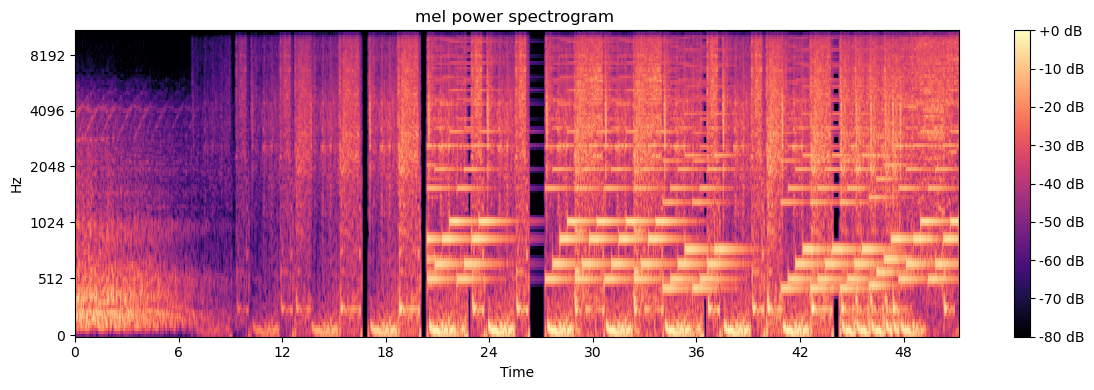

In [6]:
# test audio_search class
search = audio_search()
search.visualize_spectrogram(f'{path}fma_medium/105/105819.mp3')


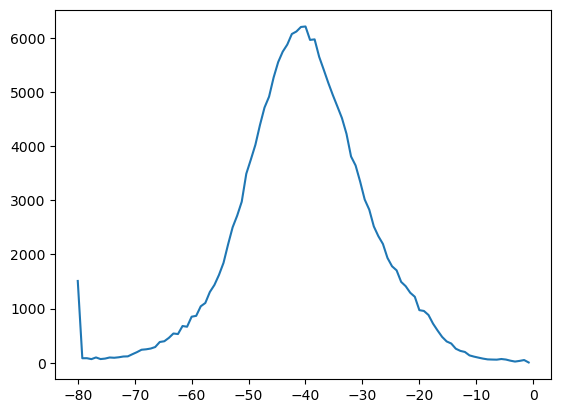

In [7]:
search.reconstruct_audio_from_save(from_png=False, de_normalize=False, integer=False)

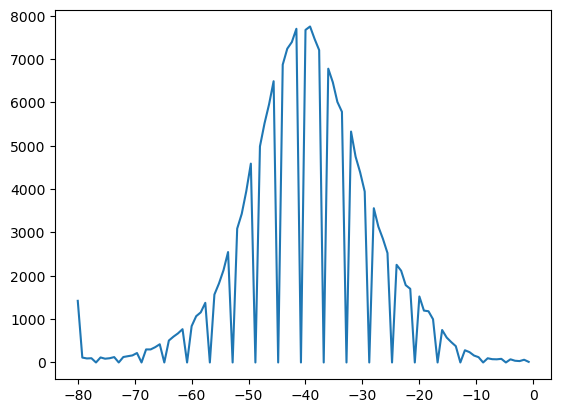

In [8]:
#test 
search.reconstruct_audio_from_save(from_png=False, de_normalize=False, integer=True)

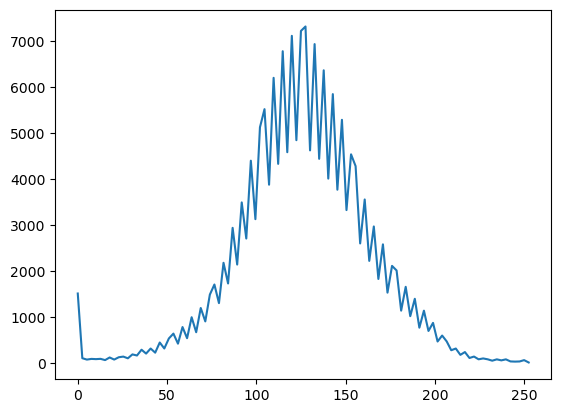

In [9]:
search.reconstruct_audio_from_save(from_png=True, de_normalize=False, integer=False, normalize = True)


In [10]:
n_fft, hop_length=2000, 150
#win=np.hanning(n_fft)
win = 50

if not os.path.exists('music_mel_spectrograms'):
    os.makedirs('music_mel_spectrograms')

if not os.path.exists('music_mel_spectrograms_30sec'):
    os.makedirs('music_mel_spectrograms_30sec')

file_names = glob.glob('fma_medium/*/*.mp3')

win=np.hanning(n_fft)

start = timeit.default_timer()

def process_files(wav_path, n_fft, hop_length, win, log, RGB = False, cut_audio=True):
    try:
      img = search.to_spectrogram(wav_path, n_fft=n_fft, hop_length=hop_length, win=win, log=log, RGB=RGB, cut_audio=cut_audio)
      if RGB == False: 
          img = img.reshape(img.shape[0], img.shape[1], 1)
          img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
      else:
          img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255

      cut_str = "_30sec" if cut_audio == False else ""
      img_name = wav_path.split('/')[-1].split('.')[0]
      img_path = f'music_mel_spectrograms{cut_str}/' + img_name + '.png'
      cv2.imwrite(img_path, img, [cv2.IMWRITE_PNG_COMPRESSION, 9])
    except Exception as e:
      print(e)

#paralel using joblib
#Parallel(n_jobs=physical_cpu_cores, backend='multiprocessing')(delayed(process_files)(wav_path, n_fft=n_fft, hop_length=hop_length, win=win, log=True, RGB=False) for wav_path in file_names)
Parallel(n_jobs=physical_cpu_cores)(delayed(process_files)(wav_path, n_fft=n_fft, hop_length=hop_length, win=win, log=True, RGB=False, cut_audio=True) for wav_path in file_names) # for some reason, this works on my AMD cpu, while the above works on my laptop.
  
end = timeit.default_timer()
print(end - start)
    

/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/home/smoothjazzuser/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile 

KeyboardInterrupt: 